# Curvilinear grids in Devito

The symbolic API of Devito enables straightforward implementation of curvilinear transformations. Such transformations have multiple applications, including modelling of complex geometries, modelling in non-recilinear domains, and variable grid resolution. Transforming the partial differential equations (PDEs) from the physical space, onto a regular, rectilinear grid enables these equations to be solved via finite-difference, before inverse transforming back to the physical domain.

## Transforming PDEs

This notebook uses the isotropic acoustic wave equation to demonstrate the coordinate transformation of PDEs. Note however, that any PDE can be transformed in such a manner. The isotropic acoustic wave equation, where $p$ and $c$ are pressure and celerity repsectively, is as follows:

$\frac{\partial^2 p}{\partial t^2} = c\left(\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2}\right)$.

Physical space dimensions $x$ and $z$ can be represented as functions of iteration dimensions $\gamma$ and $\zeta$:

$x = x(\gamma, \zeta)$,

$z = z(\gamma, \zeta)$.

Via the chain rule, the derivatives $\frac{\partial^2 p}{\partial x^2}$ and $\frac{\partial^2 p}{\partial y^2}$ can be written as derivatives in terms of $\gamma$ and $\zeta$:

$\frac{\partial^2 p}{\partial x^2} = \left(\frac{\partial^2 p}{\partial\gamma^2}\frac{\partial\gamma}{\partial x} + \frac{\partial^2 p}{\partial\gamma\partial\zeta}\frac{\partial\zeta}{\partial x}\right)\frac{\partial\zeta}{\partial x} + \frac{\partial p}{\partial\gamma}\frac{\partial^2\gamma}{\partial x^2} + \left(\frac{\partial^2 p}{\partial\gamma\partial\zeta}\frac{\partial\gamma}{\partial x} + \frac{\partial^2 p}{\partial\zeta^2}\frac{\partial\zeta}{\partial x}\right)\frac{\partial\zeta}{\partial x} + \frac{\partial p}{\partial\zeta}\frac{\partial^2 \zeta}{\partial x^2}$,

$\frac{\partial^2 p}{\partial z^2} = \left(\frac{\partial^2 p}{\partial\gamma^2}\frac{\partial\gamma}{\partial z} + \frac{\partial^2 p}{\partial\gamma\partial\zeta}\frac{\partial\zeta}{\partial z}\right)\frac{\partial\zeta}{\partial z} + \frac{\partial p}{\partial\gamma}\frac{\partial^2\gamma}{\partial z^2} + \left(\frac{\partial^2 p}{\partial\gamma\partial\zeta}\frac{\partial\gamma}{\partial z} + \frac{\partial^2 p}{\partial\zeta^2}\frac{\partial\zeta}{\partial z}\right)\frac{\partial\zeta}{\partial z} + \frac{\partial p}{\partial\zeta}\frac{\partial^2 \zeta}{\partial z^2}$.

Derivatives of iteration dimensions with respect to physical dimensions will depend on the transformation applied, and can be precalculated assuming the grid is not deformed with time. Note that depending on the transform applied, many of these terms will simplify.


## Variable grid resolution

The first application we will consider in this notebook is a variable resolution transformation. Such transformations enable grid resolution to be concentrated where it is needed, without oversampling of other areas of the domain and its associated cost. In seismic modelling, required resolution is dependent upon seismic wavespeeds which generally increase with depth. Consequently, a variable-z transformation is commonly used, stretching the grid vertically with depth to reduce the number of gridpoints required to discretise a given physical domain.

To perfom this transformation, we must first consider the required resolution at any given point. Frequency, wavespeed, and wavelength ($f$, $v$, and $\lambda$ respectively) are related to one another via:

$v = f\lambda$.

A finite difference scheme can adequately resolve a wavefield sampled with some $\alpha$ points per shortest wavelength, this number depending upon the discretisation. As such, the required grid spacing is given by:

$\Delta z(z) = \frac{v_m(z)}{\alpha f_M}$,

where the subscripts $m$ and $M$ denote minimum and maximum values respectively. Reposing this as a stretch factor $\epsilon$ relative to the vertical grid spacing at $z=0$:

$\epsilon(z) = \frac{v_m(z)}{\alpha f_M \Delta z_0}$,

where

$\Delta z_0 = \frac{v_m(z_0)}{\alpha f_M}$,

thus

$\epsilon(z) = \frac{\Delta z(z)}{\Delta z_0} = \frac{v_m(z)}{v_m(z_0)}$.

In this case, the physical dimensions are related to the iteration dimensions via

$\gamma = x$,

and

$\zeta = \frac{z}{\epsilon(z)}$,

simplifying the transformed derivatives to

$\frac{\partial^2 p}{\partial x^2} = \frac{\partial^2 p}{\partial\gamma^2}$

$\frac{\partial^2 p}{\partial z^2} = \frac{\partial^2 p}{\partial\zeta^2}\left(\frac{\partial\zeta}{\partial z}\right)^2 + \frac{\partial p}{\partial\zeta}\frac{\partial^2 \zeta}{\partial z^2}$

where

$\frac{\partial \zeta}{\partial z} = \frac{1}{\epsilon}$,

and

$\frac{\partial^2 \zeta}{\partial z^2} = -\frac{1}{\epsilon^2}\frac{\partial\epsilon}{\partial z}$.

## Velocity model

The first step is to create a velocity model on a regular grid, for which a more optimal vertical resolution can be found.

Operator `initdamp` ran in 0.01 s


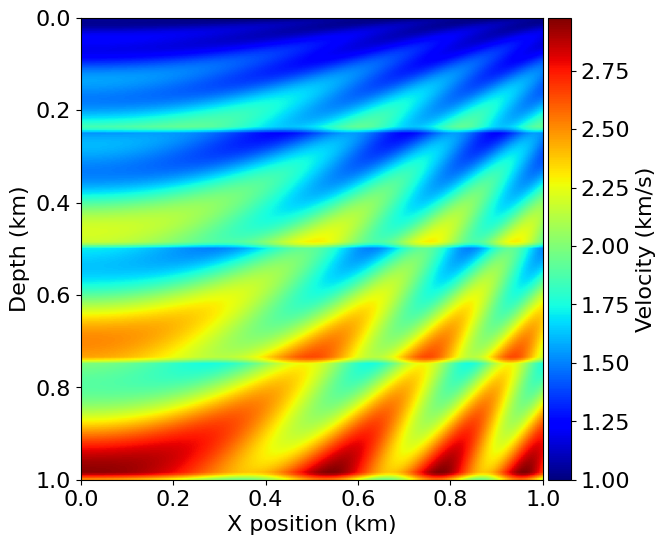

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import devito as dv

from scipy.signal import sawtooth
from examples.seismic import Model, plot_velocity

x_vals = np.linspace(0., 1., 201)
z_vals = np.linspace(0., 1., 201)

mshx, mshz = np.meshgrid(x_vals, z_vals, indexing='ij')

c = 1.2 + 1.*mshz + 0.3*mshz**0.5*(1+np.sin(20*mshx**2 + 40*mshz**0.5)) + 0.2*sawtooth(8*np.pi*mshz, width=0.95)

shape = (201, 201)
spacing = (5., 5.)
origin = (0., 0.)
dimensions = (dv.Dimension('x'), dv.Dimension('z'))

model = Model(vp=c, origin=origin, shape=shape, spacing=spacing,
              dimensions=dimensions, space_order=2, nbl=10, bcs="damp")

plot_velocity(model)

For comparison, we will first set this model up and run it with a regular grid.

Operator `Kernel` ran in 0.05 s


0.5807725


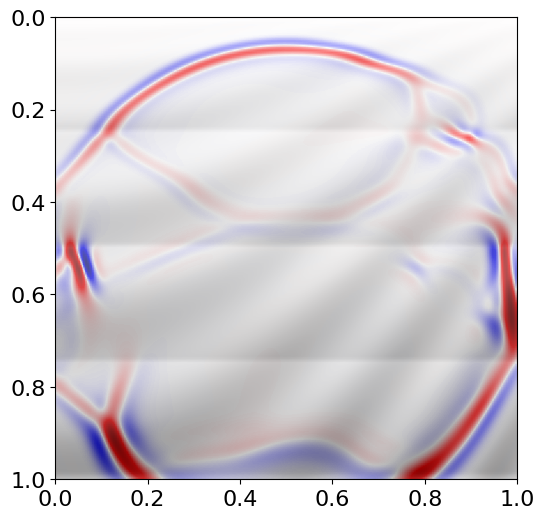

In [2]:
from examples.seismic import TimeAxis, RickerSource

t0 = 0.  # Simulation starts a t=0
tn = 300.  # Simulation last 1 second (1000 ms)
dt = 0.8*model.critical_dt  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.030  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range, interpolation='sinc')

# Center source
src.coordinates.data[0, :] = np.array(model.domain_size) * .5

# Set up fields
p = dv.TimeFunction(name='p', grid=model.grid, space_order=8, time_order=2)
pde = model.m * p.dt2 - p.laplace + model.damp * p.dt
stencil = dv.Eq(p.forward, dv.solve(pde, p.forward))

src_term = src.inject(field=p.forward, expr=src)

op = dv.Operator([stencil] + src_term)
op.apply(dt=dt)

vmax = np.amax(np.abs(p.data[-1]))
print(vmax)
extent = (0, 1, 1, 0)
plt.imshow(model.vp.data[10:-10, 10:-10].T, cmap='Greys', extent=extent)
plt.imshow(p.data[-1, 10:-10, 10:-10].T, cmap='seismic', alpha=0.6, vmax=vmax, vmin=-vmax, extent=extent)
plt.show()

The next step is to calculate the stretch factor for the curvilinear grid. A linear stretch factor is used for simplicity, although one could calculate derivatives of the stretch factor with respect to $z$ using finite differences.

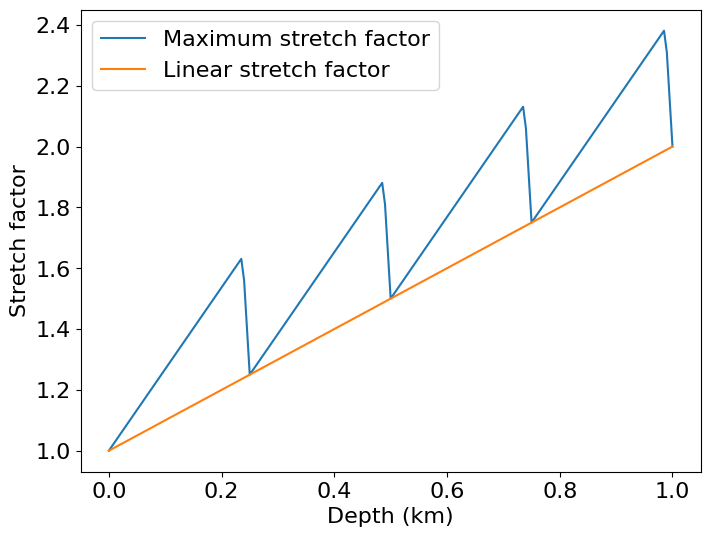

In [3]:
eps_opt = np.amin(c, axis=0)/np.amin(c[:, 0])  # Optimal stretch factor

# Linear stretch factor
epsdz = np.amin((eps_opt[1:] - eps_opt[0])/z_vals[1:])
eps = eps_opt[0] + z_vals*epsdz

plt.plot(z_vals, eps_opt, label="Maximum stretch factor")
plt.plot(z_vals, eps, label="Linear stretch factor")
plt.xlabel("Depth (km)")
plt.ylabel("Stretch factor")
plt.legend()
plt.show()

In [4]:
# FIXME: Needs explanation
def z_to_zeta(z):
    """Map from physical to the iteration space"""
    return (1/epsdz)*np.log(1 + epsdz*z)


def zeta_to_z(zeta):
    """Map from the iteration space to the physical"""
    return (np.exp(epsdz*zeta) - 1)/epsdz

# Get number of gridpoints in z direction with curvilinear grid
zeta_extent = z_to_zeta(1.)
zeta_size = 1 + int(np.ceil(200*zeta_extent))

# Percentage reduction in grid size
percent_reduction = 100*(201 - zeta_size)/201
print("The curvilinear transformation reduces the number of gridpoints in the z dimension by %.2f%%" % percent_reduction)

The curvilinear transformation reduces the number of gridpoints in the z dimension by 30.35%


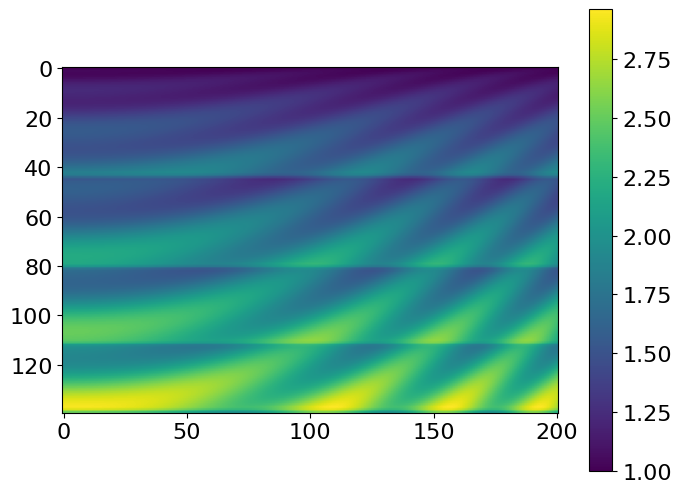

In [5]:
from scipy.ndimage import map_coordinates

# Get the curvilinear grid and resample the model
zeta_vals = np.linspace(0., zeta_extent, zeta_size)
curvilinear_z_vals = zeta_to_z(zeta_vals)

mshgamma, mshzeta = np.meshgrid(x_vals, curvilinear_z_vals, indexing='ij')

coordinates = np.vstack((200*mshgamma[np.newaxis], 200*mshzeta[np.newaxis]))
c_curv = map_coordinates(c, coordinates)

# Plot warped velocity field
plt.imshow(c_curv.T)
plt.colorbar()
plt.show()

Creating a new curvilinear model.

Operator `initdamp` ran in 0.01 s
Operator `Kernel` ran in 0.05 s


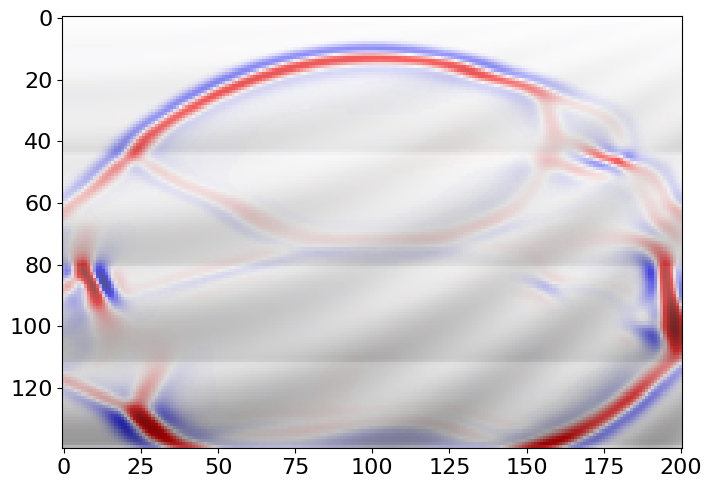

0.7956305


In [6]:
shape_curv = (201, zeta_size)

model_curv = Model(vp=c_curv, origin=origin, shape=shape_curv, spacing=spacing,
                   dimensions=dimensions, space_order=2, nbl=10, bcs="damp")

# Set up fields
p_curv = dv.TimeFunction(name='p', grid=model_curv.grid, space_order=8, time_order=2)

# dzeta/dz and d^2zeta/dz^2
eps_curv = dv.Function(name='epsilon', shape=(model_curv.grid.shape[-1],),
                       dimensions=(model_curv.grid.dimensions[-1],))
eps_curv.data[:] = np.pad(map_coordinates(eps, (200*curvilinear_z_vals,)), 10, mode='edge')

zetadz = 1/eps_curv
# FIXME: Think either this is wrong or I've lost a factor of 1000 somewhere
zetadz2 = 0  # -epsdz/(1000*eps_curv**2)

# Define the transformed derivative
# FIXME: Dimensions need correcting
pdz2 = p_curv.dy2*zetadz**2 + p_curv.dy*zetadz2

# Define the transformed PDE
pde_curv = model_curv.m * p_curv.dt2 - (p_curv.dx2 + pdz2) + model_curv.damp * p_curv.dt
stencil_curv = dv.Eq(p_curv.forward, dv.solve(pde_curv, p_curv.forward))

src_curv = RickerSource(name='src', grid=model_curv.grid, f0=f0,
                        npoint=1, time_range=time_range, interpolation='sinc')

# Center source
src_curv.coordinates.data[0, 0] = 500.
src_curv.coordinates.data[0, 1] = 1000.*z_to_zeta(0.5)

src_term_curv = src_curv.inject(field=p_curv.forward, expr=src_curv)

op_curv = dv.Operator([stencil_curv] + src_term_curv)
op_curv.apply(dt=dt)

vmax = np.amax(np.abs(p_curv.data[-1]))
plt.imshow(model_curv.vp.data[10:-10, 10:-10].T, cmap='Greys')
plt.imshow(p_curv.data[-1, 10:-10, 10:-10].T, cmap='seismic', alpha=0.6, vmax=vmax, vmin=-vmax)
plt.show()

print(vmax)

0.7974024


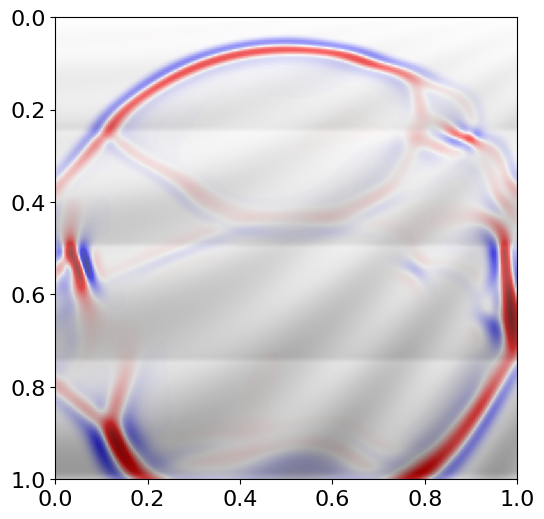

In [10]:
# Reverse the transformation for plotting in physical space
physical_zeta_vals = z_to_zeta(z_vals)

# FIXME: Redefined mshx, mshz
mshx, mshz = np.meshgrid(x_vals, physical_zeta_vals, indexing='ij')
coordinates = np.vstack((200*mshx[np.newaxis], 200*mshz[np.newaxis]))
p_phys = map_coordinates(p_curv.data[-1, 10:-10, 10:-10], coordinates)

vmax = np.amax(np.abs(p_phys))
extent = (0, 1, 1, 0)
plt.imshow(c.T, cmap='Greys', extent=extent)
plt.imshow(p_phys.T, cmap='seismic', alpha=0.6, vmax=vmax, vmin=-vmax, extent=extent)
plt.show()

In [8]:
## Variable grid resolution
# FIXME: Make this sodding thing all SI units

In [9]:
## Flattening transform